# LDA for Power Law: Scientific Papers

In [10]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pyLDAvis.gensim
import pickle 
import pyLDAvis

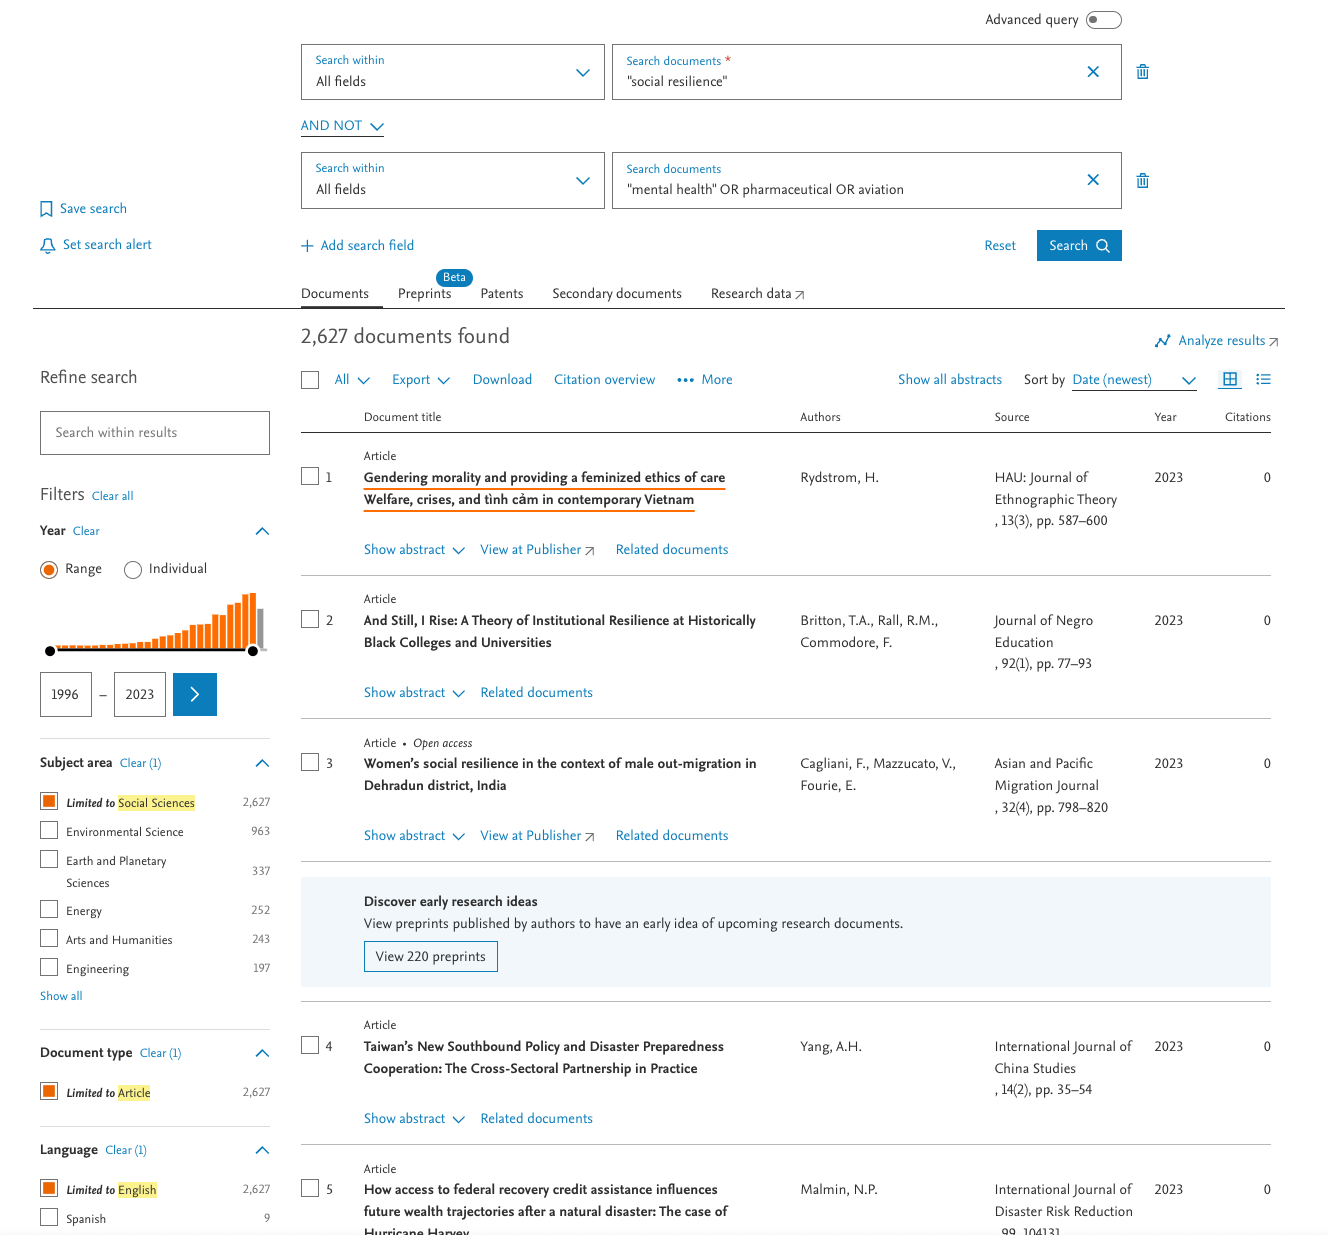
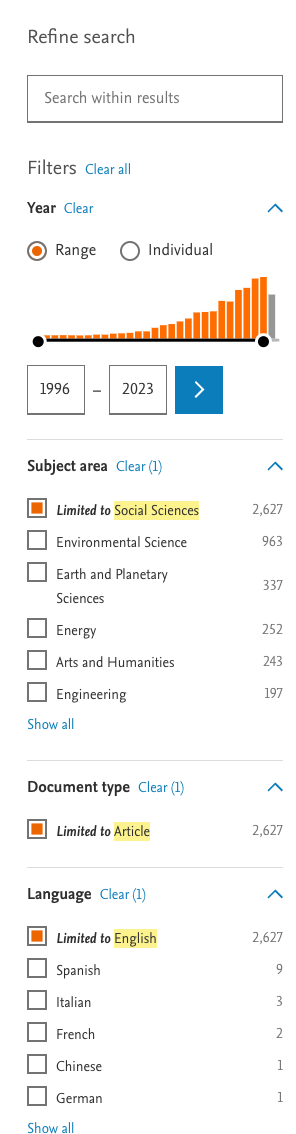

# Read data

In [2]:
data = pd.read_csv('../data/papers.csv')[['Authors','Title', 'Year', 'Abstract', 'Author Keywords', 'Index Keywords', 'Funding Texts', 'Cited by']]
data.head()

,Authors,Title,Year,Abstract,Author Keywords,Index Keywords,Funding Texts,Cited by
0,Tao D.; Zhang R.; Xu J.; Zheng L.; Zhang G.; Z...,Understanding the nature of early agriculture ...,2023,Agriculture constitutes the economic foundatio...,Agricultural sustainability; Archaeobotany; Ce...,NaN,This research was supported by Chinese Nationa...,0
1,Promkhambut A.; Yokying P.; Woods K.; Fisher M...,Rethinking agrarian transition in Southeast As...,2023,This paper contributes to new understandings o...,Agrarian transition; Rice; Smallholder persist...,Southeast Asia; Thailand; accessibility; agrar...,Funding text 1: The authors would like to than...,7
2,Rasekhi S.; Mofidi-Chelan M.; Skataric G.; Vär...,Sustainability of the local stakeholder networ...,2023,Sustainable land management (SLM) as a holisti...,Cooperation; Social capital; Social resilience...,Iran; grassland; land management; rangeland; s...,NaN,0
3,Oktavianus J.; Davidson B.,Countering terrorism on social media: An analy...,2023,This study scrutinizes the nature of online ci...,Collective actions; counter-terrorism; framing...,NaN,NaN,0
4,Junger L.; Davids P.; Stöglehner G.; Hartmann T.,Multidimensional resilience - flood recovery o...,2023,Flood damages are increasing and thus flood re...,Financial resilience; Flood risk management; L...,NaN,"Funding text 1: Besides public funding, the in...",0


# Data cleaning

In [3]:
# Combine and clean keywords
data['All Keywords'] = data['Author Keywords'].fillna('') + ' ' + data['Index Keywords'].fillna('')
data['All Keywords'] = data['All Keywords'].apply(lambda x: re.sub(r'\s+', ' ', x.strip()))
data.head()

,Authors,Title,Year,Abstract,Author Keywords,Index Keywords,Funding Texts,Cited by,All Keywords
0,Tao D.; Zhang R.; Xu J.; Zheng L.; Zhang G.; Z...,Understanding the nature of early agriculture ...,2023,Agriculture constitutes the economic foundatio...,Agricultural sustainability; Archaeobotany; Ce...,NaN,This research was supported by Chinese Nationa...,0,Agricultural sustainability; Archaeobotany; Ce...
1,Promkhambut A.; Yokying P.; Woods K.; Fisher M...,Rethinking agrarian transition in Southeast As...,2023,This paper contributes to new understandings o...,Agrarian transition; Rice; Smallholder persist...,Southeast Asia; Thailand; accessibility; agrar...,Funding text 1: The authors would like to than...,7,Agrarian transition; Rice; Smallholder persist...
2,Rasekhi S.; Mofidi-Chelan M.; Skataric G.; Vär...,Sustainability of the local stakeholder networ...,2023,Sustainable land management (SLM) as a holisti...,Cooperation; Social capital; Social resilience...,Iran; grassland; land management; rangeland; s...,NaN,0,Cooperation; Social capital; Social resilience...
3,Oktavianus J.; Davidson B.,Countering terrorism on social media: An analy...,2023,This study scrutinizes the nature of online ci...,Collective actions; counter-terrorism; framing...,NaN,NaN,0,Collective actions; counter-terrorism; framing...
4,Junger L.; Davids P.; Stöglehner G.; Hartmann T.,Multidimensional resilience - flood recovery o...,2023,Flood damages are increasing and thus flood re...,Financial resilience; Flood risk management; L...,NaN,"Funding text 1: Besides public funding, the in...",0,Financial resilience; Flood risk management; L...


# LDA Analysis

## Optimal Number of topics

### Log-likehood

The optimal number of topics is 5


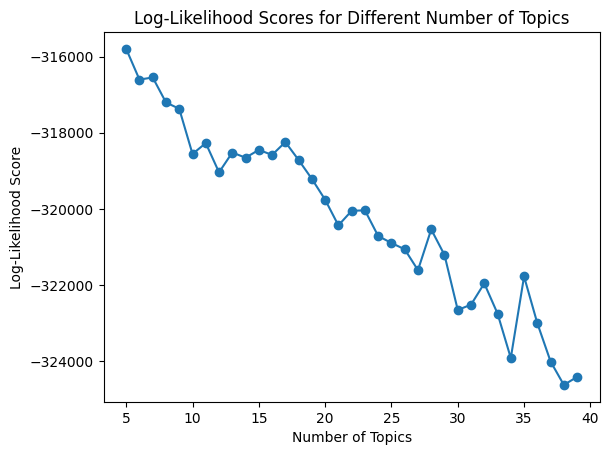

In [4]:
# Vectorize the keywords
vectorizer = CountVectorizer(max_df=0.85, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(data['All Keywords'])

topic_range = range(5, 40)
log_likelihoods = []

for num_topics in topic_range:
    lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda_model.fit(dtm)
    log_likelihoods.append(lda_model.score(dtm))
    
optimal_num_topics = topic_range[log_likelihoods.index(max(log_likelihoods))]
print(f"The optimal number of topics is {optimal_num_topics}")

# Plot the log-likelihood scores
plt.plot(topic_range, log_likelihoods, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Log-Likelihood Score')
plt.title('Log-Likelihood Scores for Different Number of Topics')
plt.show()

### Coherence Metric

100%|██████████| 35/35 [04:07<00:00,  7.08s/it]


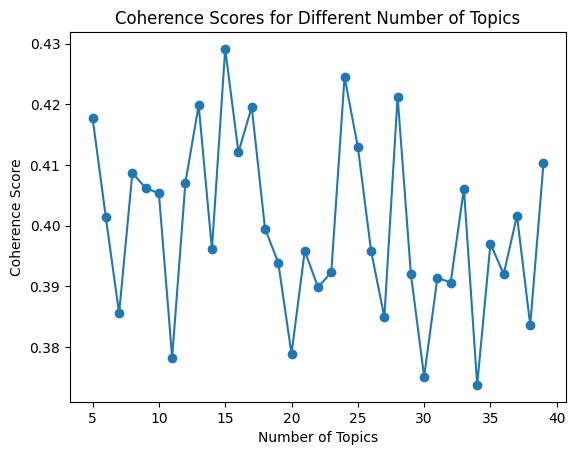

The optimal number of topics is 15


In [5]:
# Convert the keywords data to a list of lists format
keywords_list = data['All Keywords'].apply(lambda x: x.split()).tolist()

# Create a Gensim dictionary and corpus
dictionary = Dictionary(keywords_list)
corpus = [dictionary.doc2bow(text) for text in keywords_list]

# Define a function to compute coherence score for a given number of topics
def compute_coherence_values(dictionary, corpus, texts, limit, start=5, step=1):
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
        dtm = vectorizer.fit_transform(data['All Keywords'])
        model.fit(dtm)
        model_list.append(model)
        
        topics = []
        for topic_idx, topic in enumerate(model.components_):
            top_keywords = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-10 - 1:-1]]
            topics.append(top_keywords)
        
        cm = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(cm.get_coherence())
    return model_list, coherence_values

# Compute coherence values for a range of topics
start, limit, step = 5, 40, 1
model_list, coherence_values = compute_coherence_values(dictionary, corpus, keywords_list, limit, start, step)

# Determine the optimal number of topics based on coherence score
optimal_num_topics = start + np.argmax(coherence_values) * step

# Plot the coherence scores
plt.plot(range(start, limit, step), coherence_values, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Coherence Scores for Different Number of Topics')
plt.show()

print(f"The optimal number of topics is {optimal_num_topics}")


In [6]:
# Create a DataFrame for the coherence values
coherence_df = pd.DataFrame({
    'Number of Topics': range(start, limit, step),
    'Coherence Score': coherence_values
})

# Save the coherence values to an Excel file
coherence_df.to_excel('../data/coherence_scores.xlsx', index=False)

# LDA Optimal Model

In [7]:
# Get the optimal model
optimal_model = model_list[np.argmax(coherence_values)]

# Display top keywords for each topic in the optimal model
def display_top_keywords(model, feature_names, num_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        top_keywords = [feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
        topics[f'Topic {topic_idx + 1}'] = top_keywords
    return topics

feature_names = vectorizer.get_feature_names_out()
top_keywords_per_topic = display_top_keywords(optimal_model, feature_names, 10)

# Print the top keywords for each topic
for topic, keywords in top_keywords_per_topic.items():
    print(f"{topic}: {', '.join(keywords)}")

Topic 1: analysis, spatial, health, resilience, urban, vulnerability, socioeconomic, gis, population, area
Topic 2: rural, development, community, management, resilience, resource, governance, food, tourism, economic
Topic 3: resilience, urban, development, making, policy, sustainable, decision, planning, sustainability, framework
Topic 4: urban, development, tourism, planning, resilience, city, area, knowledge, sustainable, economic
Topic 5: social, human, health, adult, female, male, work, aged, article, migration
Topic 6: migration, population, cultural, rights, identity, africa, environmental, bangladesh, timor, relations
Topic 7: disaster, united, states, informal, new, political, housing, management, land, neoliberalism
Topic 8: housing, islands, resilience, european, urban, support, solomon, union, decision, island
Topic 9: analysis, water, resilience, information, social, model, infrastructure, development, china, spatiotemporal
Topic 10: management, fishery, fishing, fisheries

In [8]:
# Save the topics and keywords to a DataFrame
topics_df = pd.DataFrame(top_keywords_per_topic).T
topics_df.columns = [f'Top Keyword {i+1}' for i in range(topics_df.shape[1])]

# Save the topics and keywords to an Excel file
topics_df.to_excel('../data/topics_keywords.xlsx', index_label='Topic')

## Topic name by AI

## Assign Topics to documents

In [9]:
# Assign topics to documents
dtm = vectorizer.transform(data['All Keywords'])
document_topic_dist = optimal_model.transform(dtm)

# Assign the topic with the highest probability to each document
assigned_topics = np.argmax(document_topic_dist, axis=1)

# Add the assigned topics to the original dataframe
data['K-Topic'] = assigned_topics
data.head()

,Authors,Title,Year,Abstract,Author Keywords,Index Keywords,Funding Texts,Cited by,All Keywords,K-Topic
0,Tao D.; Zhang R.; Xu J.; Zheng L.; Zhang G.; Z...,Understanding the nature of early agriculture ...,2023,Agriculture constitutes the economic foundatio...,Agricultural sustainability; Archaeobotany; Ce...,NaN,This research was supported by Chinese Nationa...,0,Agricultural sustainability; Archaeobotany; Ce...,9
1,Promkhambut A.; Yokying P.; Woods K.; Fisher M...,Rethinking agrarian transition in Southeast As...,2023,This paper contributes to new understandings o...,Agrarian transition; Rice; Smallholder persist...,Southeast Asia; Thailand; accessibility; agrar...,Funding text 1: The authors would like to than...,7,Agrarian transition; Rice; Smallholder persist...,0
2,Rasekhi S.; Mofidi-Chelan M.; Skataric G.; Vär...,Sustainability of the local stakeholder networ...,2023,Sustainable land management (SLM) as a holisti...,Cooperation; Social capital; Social resilience...,Iran; grassland; land management; rangeland; s...,NaN,0,Cooperation; Social capital; Social resilience...,11
3,Oktavianus J.; Davidson B.,Countering terrorism on social media: An analy...,2023,This study scrutinizes the nature of online ci...,Collective actions; counter-terrorism; framing...,NaN,NaN,0,Collective actions; counter-terrorism; framing...,13
4,Junger L.; Davids P.; Stöglehner G.; Hartmann T.,Multidimensional resilience - flood recovery o...,2023,Flood damages are increasing and thus flood re...,Financial resilience; Flood risk management; L...,NaN,"Funding text 1: Besides public funding, the in...",0,Financial resilience; Flood risk management; L...,14


In [20]:
data['K-Topic'] = data.apply(lambda row: 'unknown' if pd.isna(row['All Keywords']) or row['All Keywords'].strip() == '' else row['K-Topic'], axis=1)

# Preparing data for power law

In [21]:
power_law = data[['Authors','Title', 'Year', 'Abstract', 'Cited by', 'All Keywords', 'K-Topic']]
power_law.head()

,Authors,Title,Year,Abstract,Cited by,All Keywords,K-Topic
0,Tao D.; Zhang R.; Xu J.; Zheng L.; Zhang G.; Z...,Understanding the nature of early agriculture ...,2023,Agriculture constitutes the economic foundatio...,0,Agricultural sustainability; Archaeobotany; Ce...,9
1,Promkhambut A.; Yokying P.; Woods K.; Fisher M...,Rethinking agrarian transition in Southeast As...,2023,This paper contributes to new understandings o...,7,Agrarian transition; Rice; Smallholder persist...,0
2,Rasekhi S.; Mofidi-Chelan M.; Skataric G.; Vär...,Sustainability of the local stakeholder networ...,2023,Sustainable land management (SLM) as a holisti...,0,Cooperation; Social capital; Social resilience...,11
3,Oktavianus J.; Davidson B.,Countering terrorism on social media: An analy...,2023,This study scrutinizes the nature of online ci...,0,Collective actions; counter-terrorism; framing...,13
4,Junger L.; Davids P.; Stöglehner G.; Hartmann T.,Multidimensional resilience - flood recovery o...,2023,Flood damages are increasing and thus flood re...,0,Financial resilience; Flood risk management; L...,14


In [22]:
# Number of topic
power_law.groupby('K-Topic')['K-Topic'].value_counts()  

TypeError: '<' not supported between instances of 'str' and 'int'

In [17]:
# Filter by topic = 0 and arrange by 'Cited by' in descending order
topic_0 = power_law[power_law['topic'] == 0].sort_values(by='Cited by', ascending=False)
topic_0

,Authors,Title,Year,Abstract,Author Keywords,Index Keywords,Funding Texts,Cited by,topic
2583,Adger W.N.,Vulnerability,2006,This paper reviews research traditions of vuln...,Adaptation; Disasters; Food insecurity; Govern...,adaptation; climate change; resilience; social...,I thank Elinor Ostrom and Marco Janssen for in...,4143,0
2593,Smit B.; Wandel J.,"Adaptation, adaptive capacity and vulnerability",2006,This paper reviews the concept of adaptation o...,Adaptation; Adaptive capacity; Applications; B...,adaptation; climate change; environmental haza...,We gratefully acknowledge the stimulus provide...,3444,0
2604,Adger W.N.; Huq S.; Brown K.; Declan C.; Mike H.,Adaptation to climate change in the developing...,2003,The world's climate is changing and will conti...,adaptation; climate change; environmental poli...,NaN,NaN,1180,0
2479,Gupta J.; Termeer C.; Klostermann J.; Meijerin...,The Adaptive Capacity Wheel: A method to asses...,2010,Climate change potentially brings continuous a...,Adaptive capacity; Climate change; Criteria; G...,article; climate change; content analysis; env...,This paper is part of ongoing research entitle...,575,0
2446,Sultana F.,"Suffering for water, suffering from water: Emo...",2011,"This article argues that resource access, use,...",Bangladesh; Conflict; Emotional geography; Gen...,Bangladesh; drinking water; gender; nature-soc...,I would like to thank Becky Elmhirst for invit...,387,0
...,...,...,...,...,...,...,...,...,...
576,Leedy T.H.,Race around the Mountain: Competitive Cycling ...,2022,Early accounts place the origins of bicycle ra...,bicycle; Coloured; racing; resilience; South A...,NaN,The author wishes to thank the Center for Afri...,0,0
254,Clegg L.; Galindo-Gutierrez J.,Green electoral performance and national clima...,2023,Does Green party electoral success lead to inc...,climate change; EU; Greens; inter-party compet...,NaN,NaN,0,0
264,Castro J.C.R.; Romero-Delgado M.,Visual Self-Representations of Households Livi...,2023,Negative social representations of poverty and...,Economic vulnerability; poverty; Spain; visual...,NaN,NaN,0,0
265,Busilacchi G.; Giovanola B.,Contemporary European Welfare State Transforma...,2023,"Over the last decades, there has been a huge d...",capability; distributive justice; luck egalita...,NaN,NaN,0,0


In [23]:
# save power law data
power_law.to_csv('../data/power_law-topics.csv', index=False)